In [1]:
# Global imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from MSMs import MSM
from scipy import linalg
from scipy.stats import entropy
import statsmodels.api as sm

In [2]:
# Functions
def arb_potential(x):
    """
    Create arbitrary 1D potential
    """
    y1=np.sin((x-np.pi))
    y2=np.sin((x-np.pi)/2)
    xtilt=0.5
    y=xtilt*y1-y2
    y=xtilt*y1+(1-xtilt)*y2

    return barrier*y

def rate_1D(potential, n_bins, beta, exp_pre=10.):
    """
    Create rate matrix from potential.

    Parameters
    ----------
    potential : function
        Potential.
    n_bins : int
        Number of bins.
    beta : float
        Thermodynamic beta.
    exp_pre : float
        Exponential pre-factor.

    Returns
    -------
    rate : np.array(N,N)
        Rate matrix.
    """
    x = np.linspace(0, 4 * np.pi, n_bins, endpoint=True)

    y = potential(x)
    y = y-np.min(y)

    # Map the continuous motion in 1D to a Markov process on a linear chain.
    # Discretize the configuration space in N bins.
    # K_{ji}=0 for j \neq i \pm 1
    rate = np.zeros((n_bins, n_bins))
    for i in range(n_bins-1):
        # Equation (41)
        rate[i, i + 1] = exp_pre * np.exp(- beta * (y[i] - y[i + 1]) / 2)
        rate[i + 1, i] = exp_pre * np.exp(- beta * (y[i + 1] - y[i]) / 2)

    for j in range(n_bins):
        rate[j, j] = 0
        rate[j, j] = -np.sum(rate[:, j])

    return rate



def rate_1D_irrv(rate, rate_mod, peq, n_states, p_mod=None):
    """
    Create irreversible rate matrix.

    Parameters
    ----------
    rate : np.array(n_states,n_states)
        Reversible rate matrix.
    rate_mod : np.array(n_states,n_states)
        Number of bins.
    peq : np.array(n_states)
        Equilibrium population (stationary distribution vector)
    n_states : int
        Number of states.
    p_mod : np.array(n_states)
        Vector with alpha parameters.
    inter_rate_type : str
        "SH1", "TCV1", "TCV2" or "TCV3"

    Returns
    -------
    irrev_rate : np.array(2*n_states,2*n_states)
        Irreversible rate matrix.
    """

    irrev_rate = np.zeros((n_states * 2, n_states * 2))
    irrev_rate[:n_states, :n_states] = rate



    for i in range(n_states):
        for j in range(n_states):
            # k^{(\epsilon)}
            irrev_rate[i, j] = irrev_rate[i, j] * rate_mod[i, j]

            # Skewed detailed balanced condition
            # \pi_i k_{ij}^{(\epsilon)} = \pi_j k_{ji}^{(-\epsilon)}
            # k^{(-\epsilon)}
            irrev_rate[j + n_states, i + n_states] = irrev_rate[i, j] * (peq[i] / peq[j])
    

    if p_mod is None:
        p_mod = np.zeros(n_states)


    for i in range(n_states):
        irrev_rate[i, i] = 0.0
        irrev_rate[i + n_states, i + n_states] = 0.0
        sum0 = np.sum(irrev_rate[i + n_states, n_states:] - irrev_rate[i, :n_states])
        if sum0 > 0:
            irrev_rate[i, i + n_states] = sum0 + p_mod[i]
            irrev_rate[i + n_states, i] = p_mod[i]
        else:
            irrev_rate[i, i + n_states] = p_mod[i]
            irrev_rate[i + n_states, i] = p_mod[i] - sum0

    for i in range(2 * n_states):
        # Set diagonal elements of block matrices to 0
        irrev_rate[i, i] = 0.0
        irrev_rate[i, i] = -np.sum(irrev_rate[i, :])

    return irrev_rate


def compute_eig(matrix, sorted=True):
    """
    Calculates the eigenvalues and eigenvectors of a matrix.

    Parameters
    ----------
    matrix : np.array
        Matrix
    sorted : bool
        If True, returns eigenvalues and eigenvectors sorted in a descending order.

    Returns
    -------
    eigenvalues, eigenvectors : np.array, np.array
        Eigenvalues and eigenvectors
    """
    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    if sorted:
        index = np.argsort(eigenvalues)
        index = index[::-1]
        eigenvalues_sorted = eigenvalues[index]
        eigenvectors_sorted = eigenvectors[:, index]
        return eigenvalues_sorted, eigenvectors_sorted

    return eigenvalues, eigenvectors


def loss_rate_mod(x, rate, peq, n_states, bound=True):
    """
    Create irreversible rate matrix.

    Parameters
    ----------
    x : np.array
        Optimisable paramters.
    rate : np.array(ndim,ndim)
        Reversible rate matrix.
    peq : np.array(ndim)
        Equilibrium population (stationary distribution vector)
    n_states : int
        Number of states.

    Returns
    -------
    loss : float
        Loss funtion values
    """
    if bound:
        # Bound the optimal x to be between 0 and 1
        x[x > 1] = 1
        x[x < 0] = 0

    # Construct rate mod
    stride = int(len(x) // 2.)
    rate_mod = np.eye(n_states, n_states)
    for i in range(1, n_states):
        rate_mod[i - 1, i] = x[i - 1]
        rate_mod[i, i - 1] = x[stride + i - 1]

    # Construct the transition matrix from x
    irrev_rate = rate_1D_irrv(rate, rate_mod, peq, n_states)
    #irrev_rate = np.transpose(irrev_rate)

    # Get eigenvalues and eigenvectors of the transition matrix
    eigenvalues, eigenvectors = compute_eig(np.transpose(irrev_rate), sorted=True)

    # Relaxation time is the second largest eigenvalue
    t2 = 1 / np.abs(eigenvalues[1].real)
    loss = t2


    
    # Kemeny constant
    # kemeny = np.sum(1 / np.abs(eigenvalues[1].real))
    # loss = - kemeny

    return loss


def loss_rate_mod_mfpt(x, rate, peq, n_states, bound=True):
    """
    Create irreversible rate matrix.

    Parameters
    ----------
    x : np.array
        Optimisable paramters.
    rate : np.array(ndim,ndim)
        Reversible rate matrix.
    peq : np.array(ndim)
        Equilibrium population (stationary distribution vector)
    n_states : int
        Number of states.

    Returns
    -------
    loss : float
        Loss funtion values
    """
    if bound:
        # Bound the optimal x to be between 0 and 1
        x[x > 1] = 1
        x[x < 0] = 0

    # Construct rate mod
    stride = int(len(x) // 2.)
    rate_mod = np.eye(n_states, n_states)
    for i in range(1, n_states):
        rate_mod[i - 1, i] = x[i - 1]
        rate_mod[i, i - 1] = x[stride + i - 1]

    # Construct the transition matrix from x
    irrev_rate = rate_1D_irrv(rate, rate_mod, peq, n_states)
    #irrev_rate = np.transpose(irrev_rate)
    loss = mfpt_k(linalg.expm(lagtime*irrev_rate),irrev_rate,peq,n_states,lagtime,irrev=False)

    return loss

def skewness_optimize(rate, peq, n_states,loss_func):
    # --------------------------------------------------- #
    #            Optimise the Skewness Function           #
    # --------------------------------------------------- #
    # Initial guess
    x = [1. for i in range((n_states - 1))]
    x += [0. for i in range((n_states - 1))]
    x0 = np.asarray(x)

    current_loss = loss_func(x0, rate, peq, n_states)
    f_vals = []
    x_vals = []
    

    res = minimize(loss_func, x0, args=(rate, peq, n_states),
                    method="trust-constr",
                    options={'maxiter': 200, 'xtol': 1e-5, 'gtol': 1e-6},
                    # options={'iprint': 2, 'disp': True, 'ftol': 1e-8, 'maxiter': 100000},
                    jac="2-point",
                    bounds=[[0, 1] for x in range(2 * n_states - 2)])
    
    f_vals.append(current_loss)
    x_vals.append(res.x)
    previous_loss = current_loss
    current_loss = loss_func(res.x, rate, peq, n_states)
    x0 = res.x

    min_idx = np.argmin(f_vals)
    res.x = x_vals[min_idx]

    # Bound optimal skewness function (just in case)
    res.x[res.x > 1] = 1.
    res.x[res.x < 0] = 0.

    return res


def opt_eigs(rate, peq, n_states):


    res = skewness_optimize(rate, peq, n_states,loss_rate_mod)
    #print(res.x.shape)

    # Construct rate mod
    stride = int(len(res.x) // 2.)
    rate_mod_opt = np.eye(n_states, n_states)

    for i in range(1, n_states):
        rate_mod_opt[i - 1, i] = res.x[i - 1]
        rate_mod_opt[i, i - 1] = res.x[stride + i - 1]

    # Construct optimised transtion matrix
    opt_rate = rate_1D_irrv(rate, rate_mod_opt, peq, n_states)

    # Get eigenvalues and eigenvectors of the transition matrix
    eigenvalues, eigenvectors = compute_eig(np.transpose(opt_rate), sorted=True)
    rel_time = 1 / np.abs(eigenvalues[1].real)

    return rel_time,opt_rate


def opt_mfpt(rate, peq, n_states):


    res = skewness_optimize(rate, peq, n_states,loss_rate_mod_mfpt)
    #print(res.x.shape)

    # Construct rate mod
    stride = int(len(res.x) // 2.)
    rate_mod_opt = np.eye(n_states, n_states)

    for i in range(1, n_states):
        rate_mod_opt[i - 1, i] = res.x[i - 1]
        rate_mod_opt[i, i - 1] = res.x[stride + i - 1]

    # Construct optimised transtion matrix
    opt_rate = rate_1D_irrv(rate, rate_mod_opt, peq, n_states)

    # Get eigenvalues and eigenvectors of the transition matrix
    eigenvalues, eigenvectors = compute_eig(np.transpose(opt_rate), sorted=True)
    rel_time = 1 / np.abs(eigenvalues[1].real)

    return rel_time,opt_rate



def compare_rel_time(n_states, beta = 1 / 2.4943386299999997, pre_exp = 1.):
    
    # Reversible rate
    rate = rate_1D(arb_potential, n_states, beta, pre_exp)
    eigenvalues, eigenvectors = compute_eig(rate, sorted=True)
    rate = np.transpose(rate)

    peq = eigenvectors[:, 0] / np.sum(eigenvectors[:, 0])
    if np.sum(peq < 0) > 0:
        peq = peq*-1.0


    rel_time_rev = 1. / np.abs(eigenvalues[1])

    # Irreversible Rate Matrix
    x = [1 for i in range((n_states-1))]
    x += [0 for i in range((n_states-1))]
    x = np.asarray(x)

    stride = int(len(x) // 2.)
    rate_mod = np.eye(n_states, n_states)
    for i in range(1, n_states):
        rate_mod[i-1, i] = x[i-1]
        rate_mod[i, i-1] = x[stride+i-1]


    irrev_rate = rate_1D_irrv(rate, rate_mod, peq, n_states, np.zeros(n_states))

    # Get eigenvalues and eigenvectors of the transition matrix
    eigenvalues_opt, eigenvectors_opt = compute_eig(np.transpose(irrev_rate), sorted=True)
    rel_time_irrev = 1 / np.abs(eigenvalues_opt[1].real)
    

    # Optimized irreversible rate
    rel_time_irrev_opt,opt_rate = opt_eigs(rate, peq, n_states)


    return rel_time_rev,rel_time_irrev,rel_time_irrev_opt,rate,irrev_rate,opt_rate



def mfpt(markov,rate,peq,num_state,lag_time,method="diag",irrev=False):
    tM = MSM()
    tM.M = markov
    tM.K = rate
    tM.kBT = beta
    tM.num_states = num_state
    tM.peq = peq
    tM.time_step = lag_time
    tM.num_dimensions = 1
    tM._build_mfpt_matrix_M(check=False, method=method)
    if irrev:
        return min(tM.mfpts[0,-1],tM.mfpts[0,num_state//2-1])
    else:
        return tM.mfpts[0,-1]
    


def mfpt_k(markov,rate,peq,num_state,lag_time,irrev=False):
    tM = MSM()
    tM.M = markov
    tM.K = rate
    tM.kBT = beta
    tM.num_states = num_state
    tM.peq = peq
    tM.time_step = lag_time
    tM.num_dimensions = 1
    tM._build_mfpt_matrix_K(check=False)
    if irrev:
        return min(tM.mfpts[0,-1],tM.mfpts[0,num_state//2-1])
    else:
        return tM.mfpts[0,-1]

In [60]:
# Samplers
def simple_sampler(M_t,sim_time,n_states,final = False,initial=False):
    states = np.arange(0,n_states,1)
    state_start = np.random.randint(0,n_states)
    if initial:
        state_start = 0
    P = M_t[state_start,:]
    traj = np.zeros(sim_time,dtype=int)
    traj[0] = state_start
    for i in range(1,sim_time):
        new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
        traj[i] = new_state; # record the new state.
        P = M_t[new_state,:]
    if final:
        return new_state
    return traj


def sample_pop(M_t,sim_time,n_states,n_samples,irrev = False):
    pop = []
    for n in range(n_samples):
        pop.append(simple_sampler(M_t,sim_time,n_states,final = True))
    if irrev:
        pop_n = []
        for i in pop:
            if i > n_states/2-1:
                i-=n_states/2
            pop_n.append(i)
        return pop_n
    else:
        return pop
    

def sample_traj(M_t,sim_time,n_states,n_samples,irrev = False):
    pop = []
    for n in range(n_samples):
        pop.append(simple_sampler(M_t,sim_time,n_states))
    pop = np.array(pop)
    if irrev:
        pop[pop > n_states/2-1] -= int(n_states/2)
        # for i in pop:
        #     if i > n_states/2-1:
        #         i-=n_states/2
        # return np.array(pop_n).reshape(n_samples,sim_time)

    return np.array(pop).reshape(n_samples,sim_time)


def mfpt_sampler(M_t,n_states,irrev=False):
    states = np.arange(0,n_states,1)
    state_start = 0
    P = M_t[state_start,:]
    traj = []
    new_state = 0
    if irrev:
        while new_state != n_states-1 and new_state != n_states//2-1:
            new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
            P = M_t[new_state,:]
            traj.append(new_state)
    else:
        while new_state != n_states-1:
            new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
            P = M_t[new_state,:]
            traj.append(new_state)

    return traj


def time_sampler(M_t,n_states,irrev=False):
    states = np.arange(0,n_states,1)
    state_start = 0
    P = M_t[state_start,:]
    t = 0
    new_state = 0
    if irrev:
        while new_state != n_states-1 and new_state != n_states//2-1:
            new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
            P = M_t[new_state,:]
            t += 1
    else:
        while new_state != n_states-1:
            new_state =  np.random.choice(states, p=P) # choose the new state according to the current probability distribution.
            P = M_t[new_state,:]
            t += 1

    return t

In [61]:
# Auto Correlation

def autocorrelation_function(series):

    return abs(sm.tsa.acf(series,nlags=len(series)))


def average_correlation(M,N,r=100,irrev=False):    
    AC_array = np.zeros((1000,r))
    traj_array = np.zeros((1000,r))
    for i in range(1000):
        traj = simple_sampler(M,r,N,initial=True)
        traj_array[i,:] = traj
        if len(traj)>=r:
            AC_array[i,:] = autocorrelation_function(traj)[:r]
        else:
            AC_array[i,:len(traj)] = autocorrelation_function(traj)[:r]
    return np.average(AC_array,0),np.std(AC_array,0), traj_array

In [131]:
# Initialization
beta = 1 / 2.4943386299999997
n_states = 40
pre_exp = 1.
barrier = 8.
lagtime = 0.1


rate = rate_1D(arb_potential, n_states, beta, pre_exp)
eigenvalues, eigenvectors = compute_eig(rate, sorted=True)
rate = np.transpose(rate)

peq = eigenvectors[:, 0] / np.sum(eigenvectors[:, 0])
if np.sum(peq < 0) > 0:
    peq = peq*-1.0

irpeq = np.zeros(2*n_states)
irpeq[:n_states] = peq/2
irpeq[n_states:] = peq/2

In [132]:
RT_rev,RT_irrev,RT_opt,rate_rev,rate_irrev,rate_opt = compare_rel_time(n_states)
RT_opt2,rate_opt2  = opt_mfpt(rate, peq, n_states)
print(RT_rev,"\n",RT_irrev,"\n",RT_opt,"\n",RT_opt2)

2213.5749444452067 
 679.2316933953966 
 613.4985677181614 
 643.0464335152241


In [133]:
# Transition matrices
M_rev = linalg.expm(lagtime*rate_rev)
M_irrev = linalg.expm(lagtime*rate_irrev)
M_opt = linalg.expm(lagtime*rate_opt)
M_opt2 = linalg.expm(lagtime*rate_opt2)

## MFTP

In [83]:
n = 1000
result = []
res2 = []
res3 = []
res4 = []
for i in range(n):
    result.append(time_sampler(M_rev,n_states))
    res2.append(time_sampler(M_irrev ,2*n_states,irrev=True))
    res3.append(time_sampler(M_opt,2*n_states,irrev=True))
    res4.append(time_sampler(M_opt2,2*n_states,irrev=True))

In [84]:
mfpt1 = mfpt_k(M_rev,rate_rev,peq,n_states,lagtime,irrev=False)
mfpt2 = mfpt_k(M_irrev,rate_irrev,irpeq,2*n_states,lagtime,irrev=True)
mfpt3 = mfpt_k(M_opt,rate_opt,irpeq,2*n_states,lagtime,irrev=True)
mfpt4 = mfpt_k(M_opt2,rate_opt2,irpeq,2*n_states,lagtime,irrev=True)

In [85]:
mfpt1m = mfpt(M_rev,rate_rev,peq,n_states,lagtime,irrev=False)
mfpt2m = mfpt(M_irrev,rate_irrev,irpeq,2*n_states,lagtime,irrev=True)
mfpt3m = mfpt(M_opt,rate_opt,irpeq,2*n_states,lagtime,irrev=True)
mfpt4m = mfpt(M_opt2,rate_opt2,irpeq,2*n_states,lagtime,irrev=True)

In [108]:
# MFPTs
print("              Pratical Analytical")
print("Reversible      {:.4g}  {:.4g}  {:.4g}".format(np.average(result)*lagtime, mfpt1, mfpt1m))
print("Irreversible    {:.4g}  {:.4g}  {:.4g}".format(np.average(res2)*lagtime, mfpt2, mfpt2m))
print("Optimized(RT)   {:.4g}  {:.4g}  {:.4g}".format(np.average(res3)*lagtime, mfpt3, mfpt3m))
print("Optimized(MFPT) {:.4g}  {:.4g}  {:.4g}".format(np.average(res4)*lagtime, mfpt4, mfpt4m))

              Pratical Analytical
Reversible      871.9  834.1  835.8
Irreversible    67.77  66.06  69.47
Optimized(RT)   178.9  177.6  181
Optimized(MFPT) 57.73  57.14  60.55


## Auto Correlation

In [134]:
max_timestep = 5000
rev_ac,std_rev,traj_rev = average_correlation(M_rev,n_states,max_timestep,irrev=False)
irrev_ac,std_irrev,traj_irrev = average_correlation(M_irrev,2*n_states,max_timestep,irrev=True)
op_ac,std_opt,traj_opt1 = average_correlation(M_opt,2*n_states,max_timestep,irrev=True)
op2_ac,std_opt2,traj_opt2 = average_correlation(M_opt2,2*n_states,max_timestep,irrev=True)

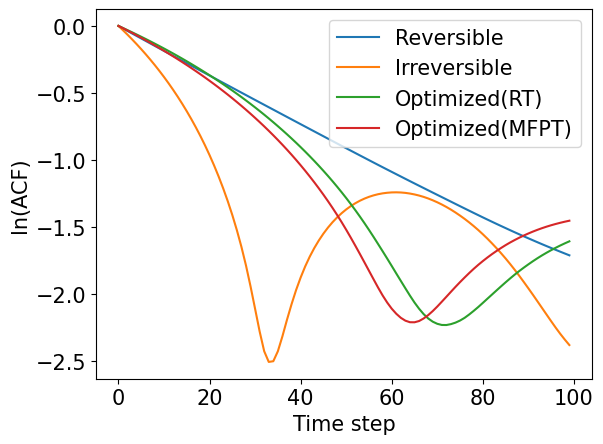

In [156]:
mpl.rcParams["font.size"]=15
plt.figure()
r = 100
plt.plot(np.log(rev_ac[:r]),label="Reversible")
plt.plot(np.log(irrev_ac[:r]),label="Irreversible")
plt.plot(np.log(op_ac[:r]),label="Optimized(RT)")
plt.plot(np.log(op2_ac[:r]),label="Optimized(MFPT)")
plt.xlabel("Time step")
plt.ylabel("ln(ACF)")
t = np.linspace(0,10000,10000)
plt.legend()


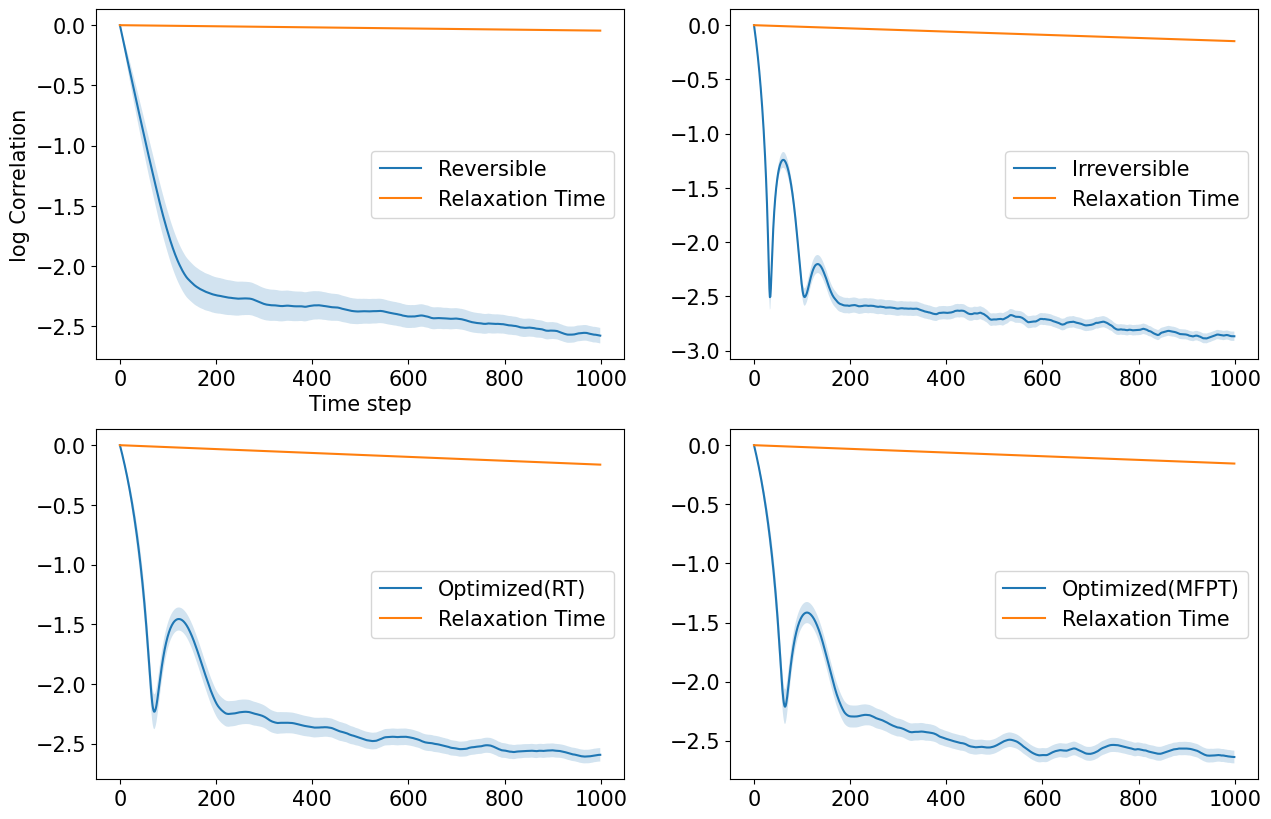

In [136]:
# Compare wiht relaxation time

t = np.linspace(0,10000,10000)
ylow = -3
xhigh = 1000
lagtime = 0.1
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.fill_between(t[:xhigh], np.log(rev_ac[:xhigh]) - std_rev[:xhigh], np.log(rev_ac[:xhigh]) + std_rev[:xhigh], alpha=0.2)
plt.plot(np.log(rev_ac[:xhigh]),label="Reversible")
plt.plot(-lagtime *t[:xhigh]/RT_rev,label = "Relaxation Time")
plt.xlabel("Time step")
plt.ylabel("log Correlation")
# plt.ylim(ylow,1)
# plt.xlim(-1,xhigh)
plt.legend()

plt.subplot(2,2,2)
plt.fill_between(t[:xhigh], np.log(irrev_ac[:xhigh]) - std_irrev[:xhigh], np.log(irrev_ac[:xhigh]) + std_irrev[:xhigh], alpha=0.2)
plt.plot(np.log(irrev_ac[:xhigh]),label="Irreversible")
plt.plot(-lagtime *t[:xhigh]/RT_irrev,label="Relaxation Time")
# plt.ylim(ylow,1)
# plt.xlim(-0.5,xhigh)
plt.legend()

plt.subplot(2,2,3)
plt.fill_between(t[:xhigh], np.log(op_ac[:xhigh]) - std_opt[:xhigh], np.log(op_ac[:xhigh]) + std_opt[:xhigh], alpha=0.2)
plt.plot(np.log(op_ac[:xhigh]),label="Optimized(RT)")
plt.plot(-lagtime *t[:xhigh]/RT_opt,label="Relaxation Time")
# plt.ylim(ylow,1)
# plt.xlim(-0.5,xhigh)
plt.legend()

plt.subplot(2,2,4)
plt.fill_between(t[:xhigh], np.log(op2_ac[:xhigh]) - std_opt2[:xhigh], np.log(op2_ac[:xhigh]) + std_opt2[:xhigh], alpha=0.2)
plt.plot(np.log(op2_ac[:xhigh]),label="Optimized(MFPT)")
plt.plot(-lagtime *t[:xhigh]/RT_opt2,label="Relaxation Time")
# plt.ylim(ylow,1)
# plt.xlim(-0.5,xhigh)
plt.legend()

In [137]:
# Save
import scipy.io
data = {"mfpt_res ": result,
"mfpt_irrev" : res2,
"mfpt_opt1" : res3,
"mfpt_opt2" : res4,
"traj_rev" : traj_rev,
"traj_irrev" : traj_irrev,
"traj_opt1" : traj_opt1,
"traj_opt2" : traj_opt2,
"v_rev": RT_rev,
"v_irrev":RT_irrev,
"v_opt1":RT_opt,
"v_opt2":RT_opt2}
scipy.io.savemat("data_1D_40_high.mat", data)

## KL divergence

In [91]:
lagtime = 0.1
# Transition matrices
M_rev = linalg.expm(lagtime*rate_rev)
M_irrev = linalg.expm(lagtime*rate_irrev)
M_opt = linalg.expm(lagtime*rate_opt)
M_opt2 = linalg.expm(lagtime*rate_opt2)

In [92]:
def KLdivergence(M,maxit,N,peq,irrev=False):
    if irrev:
        traj_array = sample_traj(M,maxit,2*N,10000,irrev)
    else:
        traj_array = sample_traj(M,maxit,N,10000,irrev)
    population = np.zeros((maxit,N),dtype=int)
    ent = []
    for i  in range(maxit):
        for n in traj_array[:,i]:
            population[i,n] +=1
            
    for i in range(maxit):
        ent.append(entropy(peq,population[i,:]))
    return ent

In [93]:
maxit = 500
ent_rev = KLdivergence(M_rev,maxit,n_states,peq)
ent_irrev = KLdivergence(M_irrev,maxit,n_states,peq,irrev=True)
ent_opt = KLdivergence(M_opt,maxit,n_states,peq,irrev=True)
ent_opt2 = KLdivergence(M_opt2,maxit,n_states,peq,irrev=True)

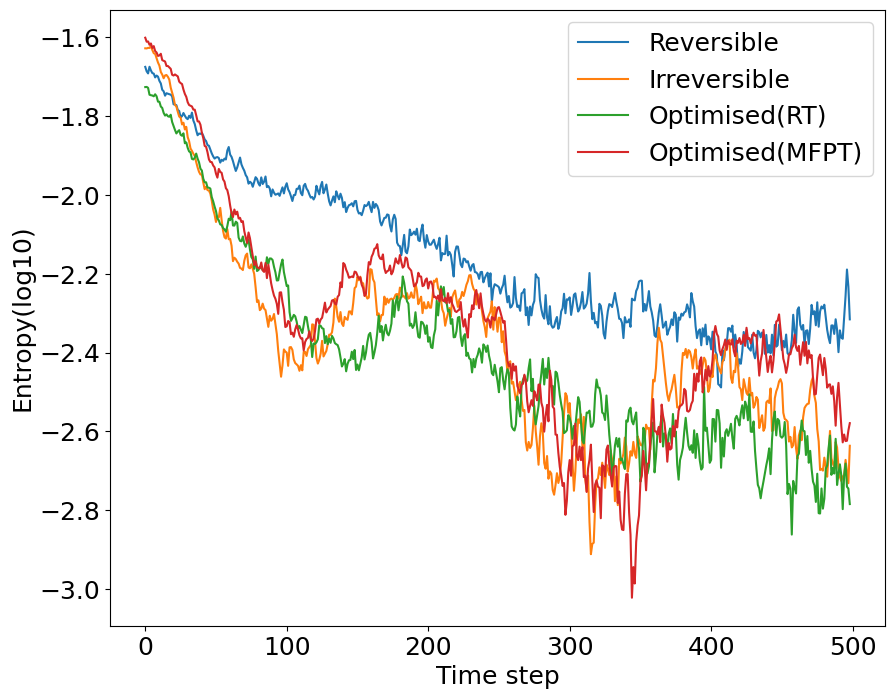

In [94]:
r = -1
mpl.rcParams["font.size"]=18
plt.figure(figsize=(10,8))
plt.plot(np.log10(ent_rev)[:r],label="Reversible")
plt.plot(np.log10(ent_irrev)[:r],label="Irreversible")
plt.plot(np.log10(ent_opt)[:r],label="Optimised(RT)")
plt.plot(np.log10(ent_opt2)[:r],label="Optimised(MFPT)")
plt.ylabel("Entropy(log10)")
plt.xlabel("Time step")
plt.legend()


Text(0.5, 0, 'state')

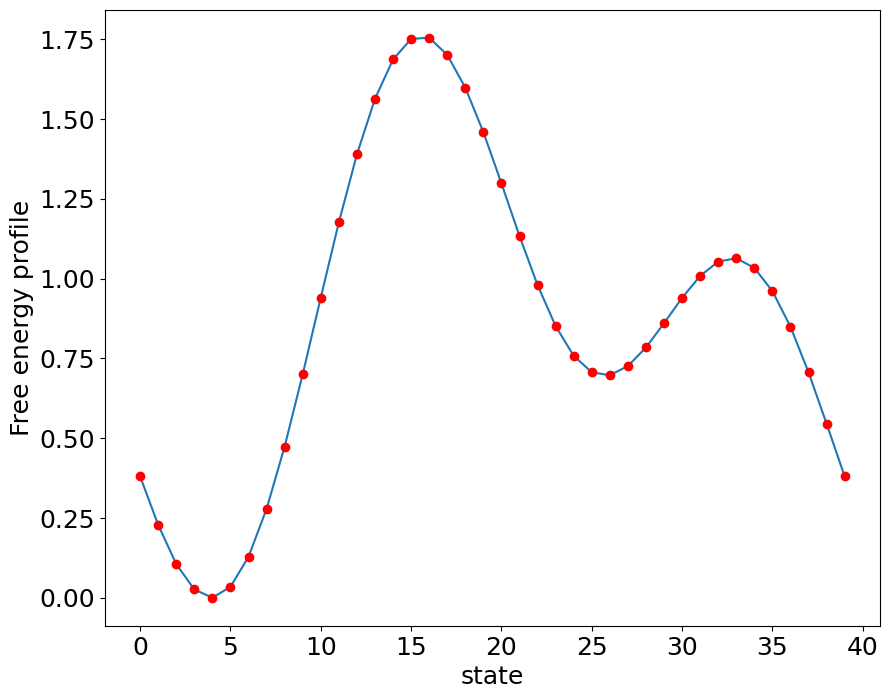

In [95]:
plt.figure(figsize=(10, 8))
plt.plot(-np.log(peq) / beta - np.min(-np.log(peq) / beta), label=r"$P_{eq}$")
plt.plot(-np.log(peq) / beta - np.min(-np.log(peq) / beta), "ro", label=r"$P_{eq}$")
#plt.plot(arb_potential(np.linspace(0, 4 * np.pi, n_states, endpoint=True)), "-", label=r"$P_{eq}$")
#plt.plot(peq*n_states, "o", label=r"$P_{eq}$")
plt.ylabel(r"Free energy profile")
plt.xlabel("state")

## Trajectories

In [138]:
for i in range(traj_irrev.shape[0]):
    for j in range(traj_irrev.shape[1]):
        if traj_irrev[i,j] >= n_states:
            traj_irrev[i,j] -= n_states

In [144]:
def traj_norm(traj_irrev):
    for i in range(traj_irrev.shape[0]):
        for j in range(traj_irrev.shape[1]):
            if traj_irrev[i,j] >= n_states:
                traj_irrev[i,j] -= n_states

In [146]:
traj_norm(traj_opt1)
traj_norm(traj_opt2)
traj_norm(traj_irrev)

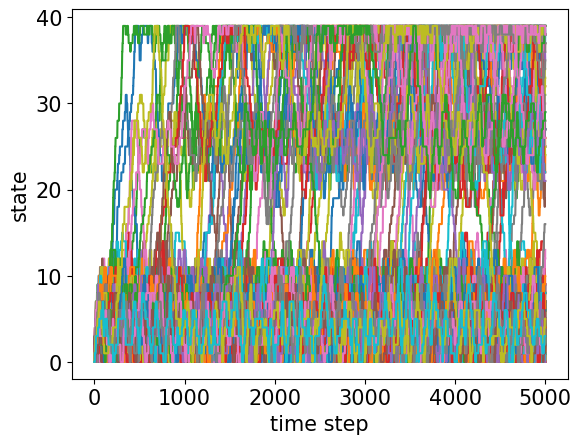

In [158]:
plt.figure()
for i in range(500):
    plt.plot(traj_irrev[i,:5000])
plt.xlabel("time step")
plt.ylabel("state")
# plt.savefig("TR_1D40_H_IRV.png")